In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, auc
import json
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import altair as alt
import matplotlib.pyplot as plt
import altair as alt

In [7]:
# Data directory
data_dir = "../../../data/unziped_data/"

# Open data with pickle
data_for_training = "../../../data/Data_For_Training/"
data_original = pd.read_csv(data_for_training + "icfes_20142.csv")

# lista de las columnas con las caracteristicas a predecir
notasz = [c for c in data_original.columns.values if c.startswith("NOTA_Z")]
deciles = [c for c in data_original.columns.values if c.startswith("DECILE")]
labels_names = notasz + deciles
puntajes = [decil.replace('DECILE_','') for decil in deciles]
# Mascara para los modelos que predicen la Nota Z
mask_nota_z = [False if 'COLE' in col or 'DEPTO' in col or 'MCPIO' in col or "ESTABLECIMIENTO" in col else True for col in features.columns]


# lista de las columnas que se van a omitir de las caracteristicas
vars_2_omit = (
    [
        "PUNT_LECTURA_CRITICA",
        "DECIL_LECTURA_CRITICA",
        "PUNT_MATEMATICAS",
        "DECIL_MATEMATICAS",
        "PUNT_C_NATURALES",
        "DECIL_C_NATURALES",
        "PUNT_SOCIALES_CIUDADANAS",
        "DECIL_SOCIALES_CIUDADANAS",
        "PUNT_RAZONA_CUANTITATIVO",
        "DECIL_RAZONA_CUANTITATIVO",
        "PUNT_COMP_CIUDADANA",
        "DECIL_COMP_CIUDADANA",
        "PUNT_INGLES",
        "DECIL_INGLES",
        "PUNT_GLOBAL",
        "ESTU_PUESTO",
    ]
    + deciles
    + notasz
)


labels = data_original[labels_names]
features = data_original.drop(vars_2_omit, axis=1)
#print(features.columns.values)

['FAMI_CUARTOSHOGAR' 'FAMI_TIENE_CELULAR' 'FAMI_TELEFONO'
 'FAMI_INGRESOFMILIARMENSUAL' 'ESTU_TRABAJAACTUALMENTE'
 'ESTU_RECIBESALARIO' 'ESTU_ANOSPREESCOLAR' 'ESTU_ANOMATRICULAPRIMERO'
 'ESTU_ANOTERMINOQUINTO' 'ESTU_ANOMATRICULASEXTO' 'ESTU_ANTECEDENTES'
 'ESTU_REPROBOPRIMERO' 'ESTU_REPROBOSEGUNDO' 'ESTU_REPROBOTERCERO'
 'ESTU_REPROBOCUARTO' 'ESTU_REPROBOQUINTO' 'ESTU_REPROBOSEXTO'
 'ESTU_REPROBOSEPTIMO' 'ESTU_REPROBOOCTAVO' 'ESTU_REPROBONOVENO'
 'ESTU_REPROBODECIMO' 'ESTU_REPROBOONCEMAS' 'ESTU_ANOSCOLEGIOACTUAL'
 'ESTU_CUANTOSCOLEGIOESTUDIO' 'ESTU_SERETIROCOLEGIO'
 'ESTU_TIPOCARRERADESEADA' 'ESTU_INSTPORPRESTIGIO' 'FAMI_TIENEINTERNET'
 'FAMI_TIENECOMPUTADOR' 'FAMI_TIENELAVADORA' 'FAMI_TIENEMICROONDAS'
 'FAMI_TIENEHORNO' 'FAMI_TIENESERVICIOTV' 'FAMI_TIENEAUTOMOVIL'
 'FAMI_TIENEDVD' 'FAMI_TIENE_NEVERA' 'FAMI_PERSONASHOGAR'
 'FAMI_NIVELSISBEN' 'FAMI_ESTRATOVIVIENDA' 'ESTU_VECESPRESENTOEXAMEN'
 'ESTU_VALORPENSIONCOLEGIO' 'ESTU_AREARESIDE' 'ESTU_ETNIA'
 'ESTU_FECHANACIMIENTO' 'ESTU_GENERO'

In [3]:
labels_names

['NOTA_Z_COLE_CODIGO_ICFES_PUNT_MATEMATICAS',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_LECTURA_CRITICA',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_C_NATURALES',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_SOCIALES_CIUDADANAS',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_RAZONA_CUANTITATIVO',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_COMP_CIUDADANA',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_INGLES',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_GLOBAL',
 'NOTA_Z_COLE_CODIGO_ICFES_ESTU_PUESTO',
 'DECILE_PUNT_MATEMATICAS',
 'DECILE_PUNT_LECTURA_CRITICA',
 'DECILE_PUNT_C_NATURALES',
 'DECILE_PUNT_SOCIALES_CIUDADANAS',
 'DECILE_PUNT_RAZONA_CUANTITATIVO',
 'DECILE_PUNT_COMP_CIUDADANA',
 'DECILE_PUNT_INGLES',
 'DECILE_PUNT_GLOBAL',
 'DECILE_ESTU_PUESTO']

In [8]:
#Cargar los escaladores
scaler_features = pickle.load(open("../models/scaler_features_20142.pkl", "rb"))
scaler_labels = pickle.load(open("../models/scaler_labels_20142.pkl", "rb"))

/home/trucupey/.virtualenvs/ICFES-SocioEconomico-Qp25LKX0/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [9]:
# Escalar las caracteristicas
X = scaler_features.transform(features)
Y = scaler_labels.transform(labels)

In [11]:
# Cargar un modelo de XGBoost
ii = 4
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model("../models/icfes_20142_{0}.model".format(labels_names[ii]))
idx = np.where(~np.isnan(Y[:, ii]))
if "NOTA_Z" in labels_names[ii]:
    dtotal = xgb.DMatrix(X[idx[0]][:, mask_nota_z])
else:
    dtotal = xgb.DMatrix(X[idx[0]])
ypred = bst.predict(dtotal)
ypred.shape

(503221,)

In [14]:
# Testear el algoritmo de prediccion de ese modelo
Y_pred_real = np.zeros(labels.shape)
Y_pred_real[idx[0],ii] = ypred
Y_pred_real = scaler_labels.inverse_transform(Y_pred_real)
Y_pred_real[:,ii]

array([-3.01452297e-04, -3.01452297e-04,  4.40339022e-01, ...,
        9.09091349e-01, -5.05007131e-01,  1.61893130e-01])

In [17]:
# Hacer las predicciones de los resultados
Y_pred = np.zeros(labels.shape)
Y_pred.fill(np.nan)
for ii in range(len(labels_names)):
    print(labels_names[ii])
    bst = xgb.Booster({'nthread': 4})  # init model
    bst.load_model("../models/icfes_20142_{0}.model".format(labels_names[ii]))
    idx = np.where(~np.isnan(Y[:, ii]))
    if "NOTA_Z" in labels_names[ii]:
        dtotal = xgb.DMatrix(X[idx[0]][:, mask_nota_z])
    else:
        dtotal = xgb.DMatrix(X[idx[0]])
    ypred = bst.predict(dtotal)
    Y_pred[idx[0],ii] = ypred

NOTA_Z_COLE_CODIGO_ICFES_PUNT_MATEMATICAS
NOTA_Z_COLE_CODIGO_ICFES_PUNT_LECTURA_CRITICA
NOTA_Z_COLE_CODIGO_ICFES_PUNT_C_NATURALES
NOTA_Z_COLE_CODIGO_ICFES_PUNT_SOCIALES_CIUDADANAS
NOTA_Z_COLE_CODIGO_ICFES_PUNT_RAZONA_CUANTITATIVO
NOTA_Z_COLE_CODIGO_ICFES_PUNT_COMP_CIUDADANA
NOTA_Z_COLE_CODIGO_ICFES_PUNT_INGLES
NOTA_Z_COLE_CODIGO_ICFES_PUNT_GLOBAL
NOTA_Z_COLE_CODIGO_ICFES_ESTU_PUESTO
DECILE_PUNT_MATEMATICAS
DECILE_PUNT_LECTURA_CRITICA
DECILE_PUNT_C_NATURALES
DECILE_PUNT_SOCIALES_CIUDADANAS
DECILE_PUNT_RAZONA_CUANTITATIVO
DECILE_PUNT_COMP_CIUDADANA
DECILE_PUNT_INGLES
DECILE_PUNT_GLOBAL
DECILE_ESTU_PUESTO


In [31]:
#Crear dataframe con labels no escaladas y prediciones no escaladas
Y_pred_real = scaler_labels.inverse_transform(Y_pred)
pred_lables = [label+'_pred' for label in labels_names]
columns = features.columns.to_list() + puntajes + labels_names + pred_lables
total_data = np.concatenate((features.values,data_original[puntajes].values, labels.values,Y_pred_real),axis=1)
data = pd.DataFrame(data=total_data,columns=columns)

In [32]:
# Compute deciles
for label in labels_names:
    if 'DECILE' in label:
        data['Deciles_{}'.format(label)] = data[label].apply(lambda x: int(x/100) if x==x else x)
    else:
        data['Deciles_{}'.format(label)] = pd.qcut(data[label],10,labels=False) 
for label in pred_lables:
    if 'DECILE' in label:
        data['Deciles_{}'.format(label)] = data[label].apply(lambda x: int(x/100) if x==x else x)
    else:
        data['Deciles_{}'.format(label)] = pd.qcut(data[label],10,labels=False) 

<AxesSubplot:ylabel='Density'>

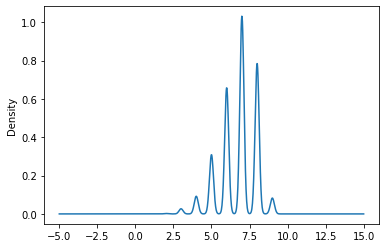

In [33]:
data[data.Deciles_DECILE_ESTU_PUESTO == 9].Deciles_DECILE_ESTU_PUESTO_pred.plot.kde()

In [34]:
# Agregar indicador para los top resultados
percentiles = [1,2,3,4,5,6,7,8,9]
for per in percentiles:
    for label in labels_names:
        data['Deciles_{}_top_{}0%'.format(label,per)] = data['Deciles_{}'.format(label)].apply(lambda x: 
            1 if x >= 10-per else 0)
    for label in pred_lables:
        data['Deciles_{}_top_{}0%'.format(label,per)] = data['Deciles_{}'.format(label)].apply(lambda x: 
            1 if x >= 10-per else 0)

In [35]:
data.to_csv(data_for_training + "icfes_20142_pred_and_deciles.csv")

In [39]:
data_no_features = data.drop(features.columns,axis=1)
data_no_features.to_csv(data_for_training + "icfes_20142_pred_and_deciles_no_features.csv")
data_no_features.columns

Index(['PUNT_MATEMATICAS', 'PUNT_LECTURA_CRITICA', 'PUNT_C_NATURALES',
       'PUNT_SOCIALES_CIUDADANAS', 'PUNT_RAZONA_CUANTITATIVO',
       'PUNT_COMP_CIUDADANA', 'PUNT_INGLES', 'PUNT_GLOBAL', 'ESTU_PUESTO',
       'NOTA_Z_COLE_CODIGO_ICFES_PUNT_MATEMATICAS',
       ...
       'Deciles_NOTA_Z_COLE_CODIGO_ICFES_ESTU_PUESTO_pred_top_90%',
       'Deciles_DECILE_PUNT_MATEMATICAS_pred_top_90%',
       'Deciles_DECILE_PUNT_LECTURA_CRITICA_pred_top_90%',
       'Deciles_DECILE_PUNT_C_NATURALES_pred_top_90%',
       'Deciles_DECILE_PUNT_SOCIALES_CIUDADANAS_pred_top_90%',
       'Deciles_DECILE_PUNT_RAZONA_CUANTITATIVO_pred_top_90%',
       'Deciles_DECILE_PUNT_COMP_CIUDADANA_pred_top_90%',
       'Deciles_DECILE_PUNT_INGLES_pred_top_90%',
       'Deciles_DECILE_PUNT_GLOBAL_pred_top_90%',
       'Deciles_DECILE_ESTU_PUESTO_pred_top_90%'],
      dtype='object', length=405)

In [ ]:
## Sacar dataframes con los datos para hacer los histogramas, también dataframes 

## Calcular precisión en la clasificacion

In [50]:
for puntaje in deciles:
    y_real = data_no_features['Deciles_{}_top_{}0%'.format(puntaje,1)].tolist()
    y_pred = data_no_features['Deciles_{}_pred_top_{}0%'.format(puntaje,1)].tolist()
    cm = confusion_matrix(y_real,y_pred, labels=[1,0] )
    print(puntaje)
    print(cm)
    print('presicion',cm[0,0]/(cm[0,0]+cm[0,1]))

DECILE_PUNT_MATEMATICAS
[[  9693  44747]
 [  2192 487769]]
presicion 0.17804922850844968
DECILE_PUNT_LECTURA_CRITICA
[[  9021  45419]
 [  2704 487257]]
presicion 0.16570536370315944
DECILE_PUNT_C_NATURALES
[[ 12448  41992]
 [  2795 487166]]
presicion 0.2286554004408523
DECILE_PUNT_SOCIALES_CIUDADANAS
[[  7107  47333]
 [  1924 488037]]
presicion 0.13054739162380602
DECILE_PUNT_RAZONA_CUANTITATIVO
[[  5569  48871]
 [  1453 488508]]
presicion 0.10229610580455548
DECILE_PUNT_COMP_CIUDADANA
[[  4427  50013]
 [  1727 488234]]
presicion 0.08131888317413666
DECILE_PUNT_INGLES
[[ 52319   2121]
 [ 12670 477291]]
presicion 0.9610396767083027
DECILE_PUNT_GLOBAL
[[ 21427  33013]
 [  4371 485590]]
presicion 0.3935892725936811
DECILE_ESTU_PUESTO
[[  1515  52925]
 [   464 489497]]
presicion 0.027828802351212344


## Chart with Altair 

<AxesSubplot:ylabel='Frequency'>

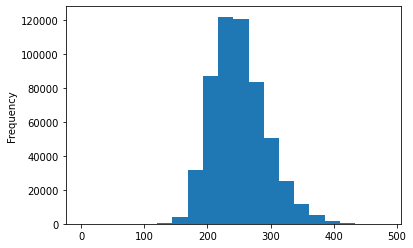

In [175]:
data_original.PUNT_GLOBAL.plot.hist(bins=20)

In [44]:
hist, bin_edges = np.histogram(data_original["ESTU_PUESTO"],bins='rice',density=True)

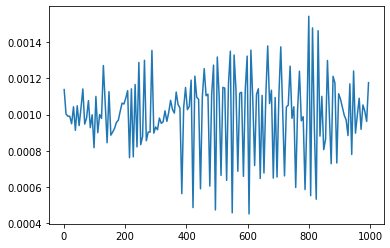

In [45]:
plt.plot(bin_edges[0:-1], hist)  # <- or here
plt.show()

In [46]:
quantiles = data_original['ESTU_PUESTO'].quantile([ii/10 for ii in range(1,10)]).values
df = pd.DataFrame.from_dict({'x': bin_edges[0:-1],'y':hist})
df['indicator'] = np.where(df['x'] < quantiles[3], 'below', 'above')

In [47]:
len(quantiles)

9

In [48]:
min_above = min(df[df['indicator'] == 'above']['x'].values)
value = min(df[df['x']==min_above]['y'].values)
print(min_above,' ',value)
df_1 = pd.DataFrame.from_dict({'x': [min_above],'y':[value],'indicator':'below'})
df = df.append(df_1)

403.0365853658537   0.0010270795666120114


In [49]:
bars = alt.Chart(df).mark_area().encode(
    x="x:Q",
    y="y:Q",
    color = "indicator",
    tooltip = ['indicator']
)

(bars).properties(width=600).interactive()

alt.Chart(...)